In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
#from sklearn.metrics import mean_squared_error
#from scipy.stats import norm
#from scipy.optimize import curve_fit
#from scipy.optimize import fsolve
import matplotlib.pyplot as plt
#%matplotlib inline+
import folium
import json
import urllib.request

url_B = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
url_G = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"

In [2]:
df = pd.read_csv(url_B, sep = ",")
df1 = df.drop(['epidemiological_week', 'last_available_date', 'is_repeated'], axis = 1)
df1.rename(columns={'last_available_confirmed' : 'confirmed', 'last_available_confirmed_per_100k_inhabitants' : 'confirmed_per_100k_inhabitants',
                    'last_available_deaths' : 'deaths','last_available_death_rate' : 'death_rate'}, inplace = True)

In [ ]:
req = urllib.request.urlopen(url_G)
content = req.read().decode('ansi')

geo = json.loads(content)

In [5]:
df_hoje = df1.loc[df['is_last'] == True, :]

label = ["Cidade", "Código IBGE", "Dia", "Último Dado", "Casos Confirmados", "Incidência de Casos", "Mortalidade", "Óbitos Confirmados", "Estado", "Novos Casos", "Novas Mortes"]
color = ['#e8615d', '#f49436', '#2d9de5', '#3bbdbd', '#634792']

In [6]:
FMT = '%Y-%m-%d'

date = df['date']
df1['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-25", FMT)).days)

In [7]:
df_estados = df1.loc[df['city'].isnull(), :].drop(['place_type', 'order_for_place'], axis = 1)
df_estados.reset_index(drop = True, inplace = True)

df_Brasil = df_estados.drop(['is_last'], axis = 1)
df_Brasil = df_Brasil.groupby('date').sum()

In [8]:
Norte = ["AC", "AM", "AP", "PA", "RO", "RR", "TO"]
Nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
Sudeste = ['ES', 'MG', 'RJ', 'SP']
Sul = ['PR', 'RS', 'SC']
Centro_oeste = ['DF', 'GO', 'MT', 'MS']

Regiao = [Nordeste, Norte, Sudeste, Sul, Centro_oeste]
reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro_oeste']

In [44]:
df_cidades = df1.loc[df['place_type'].eq('city'), :].drop(['place_type', 'order_for_place'], axis = 1)

df_paraiba = df_cidades.loc[df_cidades['state'].eq('PB'), :]
df_paraiba.reset_index(drop = True, inplace = True)

In [45]:
df_cidades['region'] = 'null'

# df_cidades.sort_values('date', ascending = True, inplace = True)
# df_cidades.reset_index(drop = True, inplace = True)
# bool_temp = pd.notnull(df_cidades["confirmed_per_100k_inhabitants"])
# df_cidades = df_cidades[bool_temp]

for r in range(len(Regiao)) :
    for a in range(len(Regiao[r])) :
        df_cidades.loc[df_cidades['state'].eq(Regiao[r][a]), 'region'] = reg[r]

In [46]:
df_Regiao = []

for r in range(len(reg)) :
    Regiao_c = list(df_cidades[(df_cidades['region'] == reg[r])].sort_values("confirmed", ascending = False)['city'].unique())
    df_Regiao.append(Regiao_c)
    
    for c in range(len(Regiao_c)) :
        df_Regiao[r][c] = df_cidades.loc[(df_cidades['city'] == Regiao_c[c]), :].drop(['estimated_population_2019'], axis = 1)
        
#         if len(df_Regiao[r][c]) > 1 : 
#             for i in range(1, len(df_Regiao[r][c])) :
#                 for j in range(3, 7) :
#                     if df_Regiao[r][c].iloc[i, j] == str or df_Regiao[r][c].iloc[i, j] < df_Regiao[r][c].iloc[i - 1, j] :
#                         temp = df_Regiao[r][c].iloc[i - 1, j]
#                         df_Regiao[r][c].iloc[i, j] = temp    

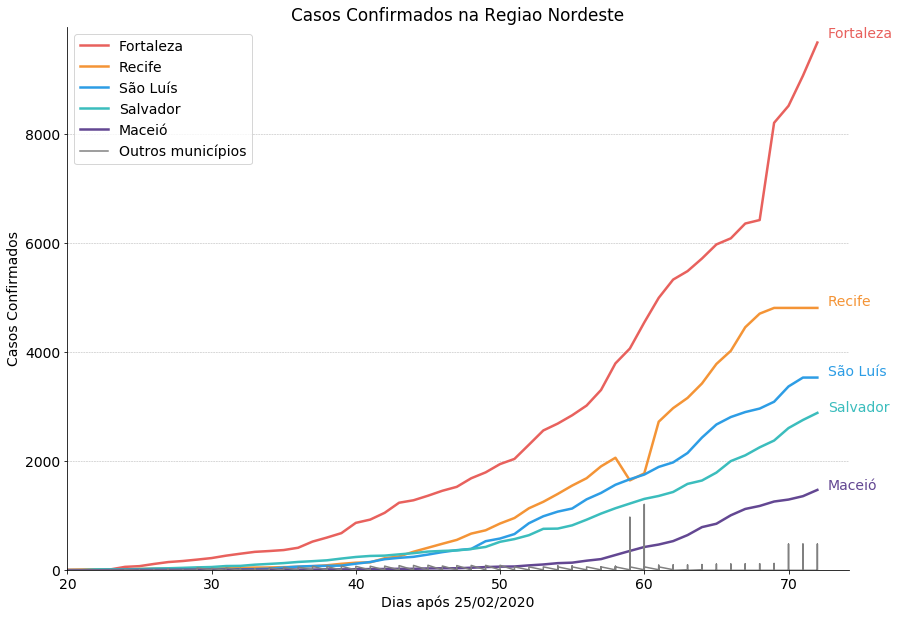

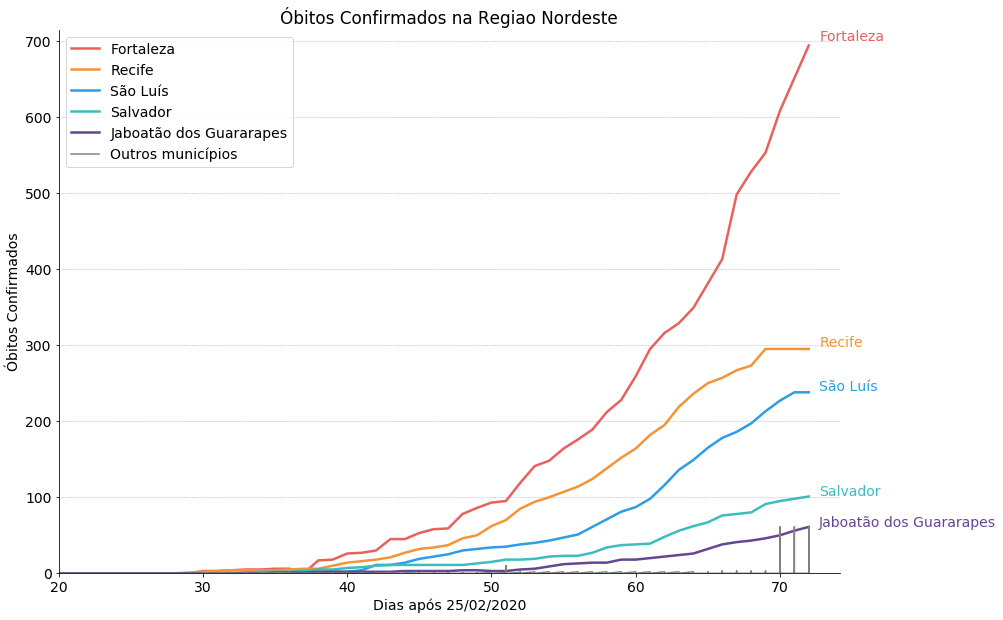

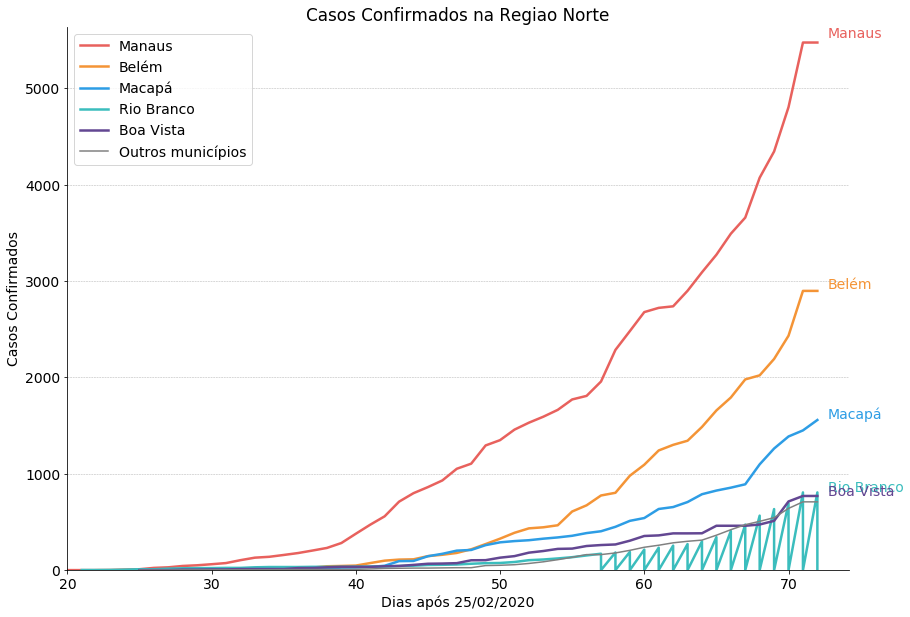

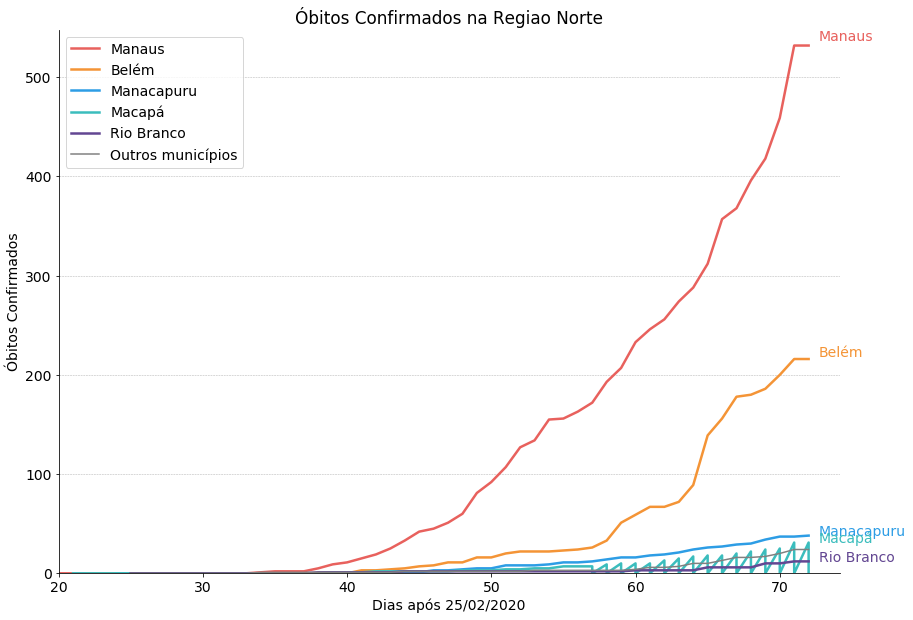

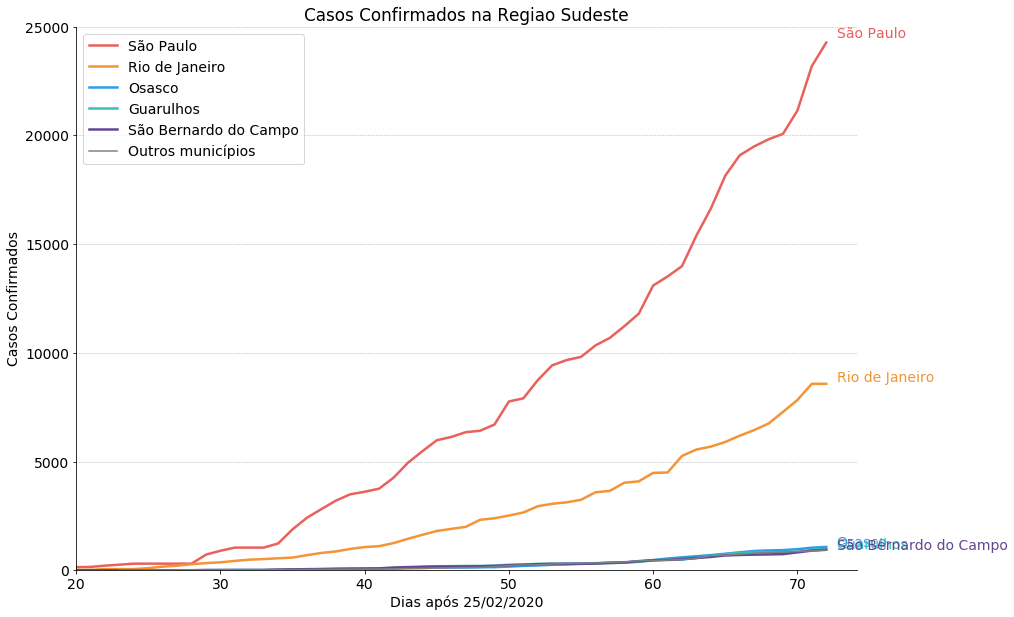

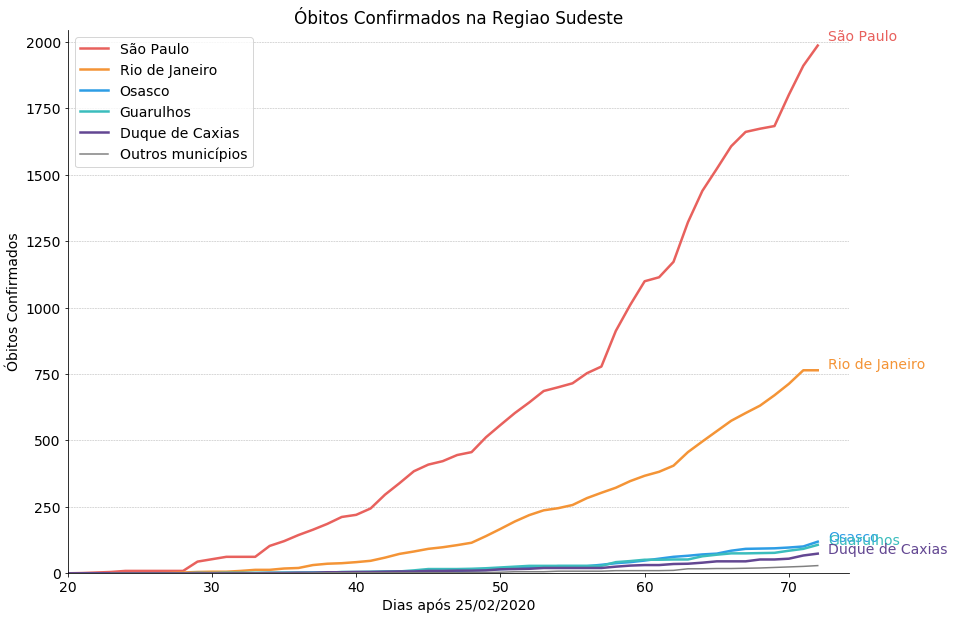

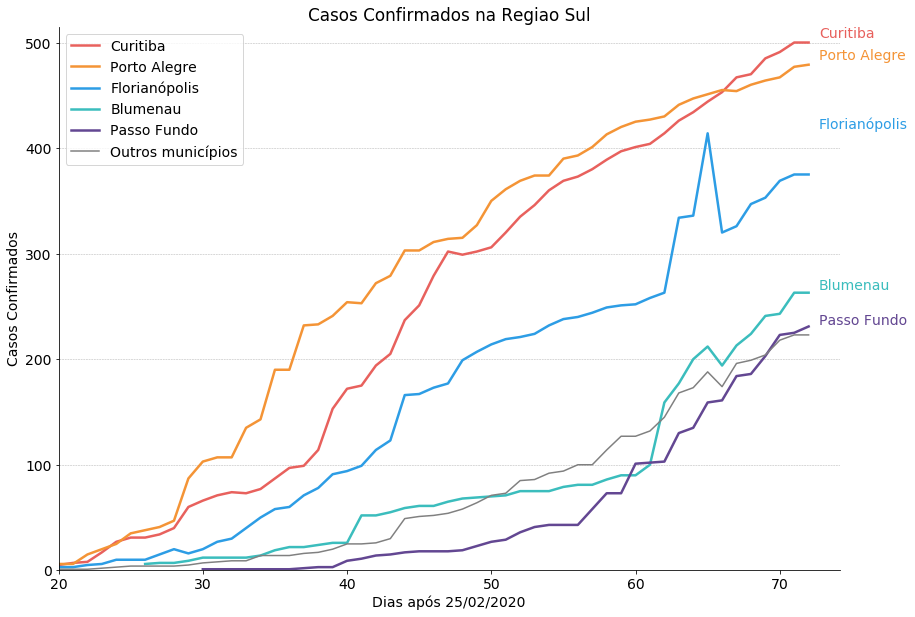

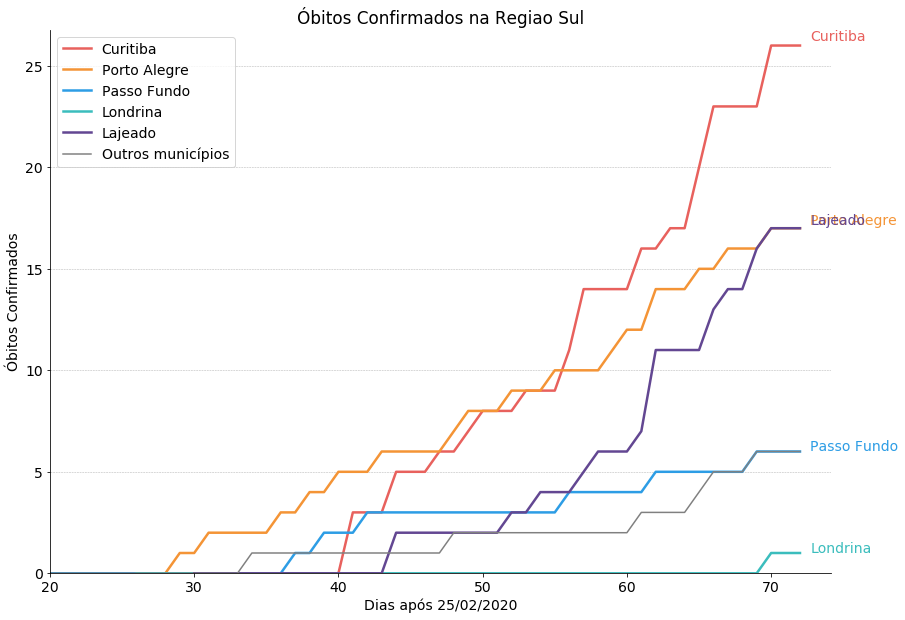

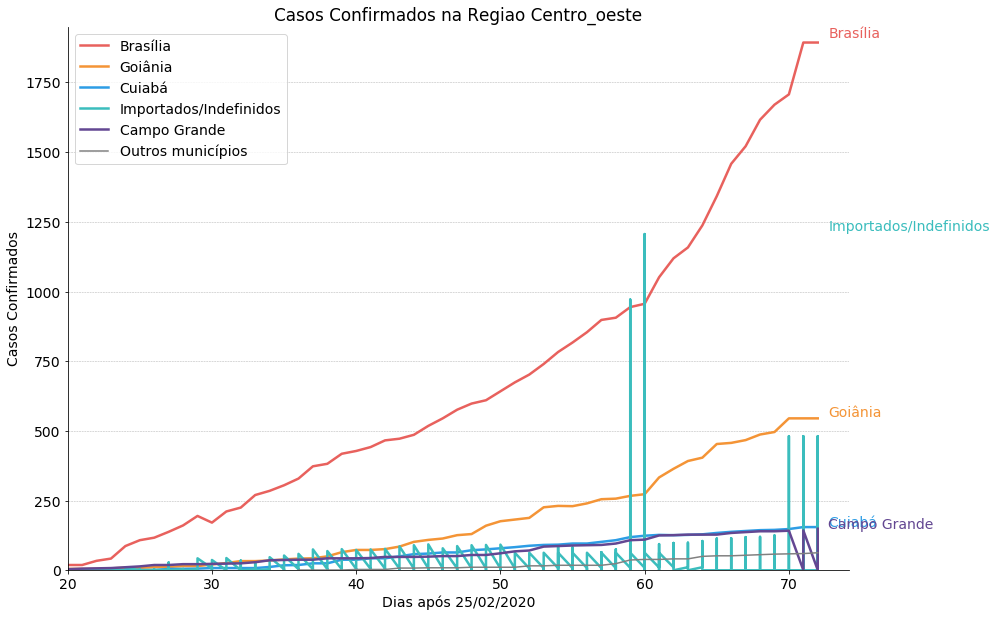

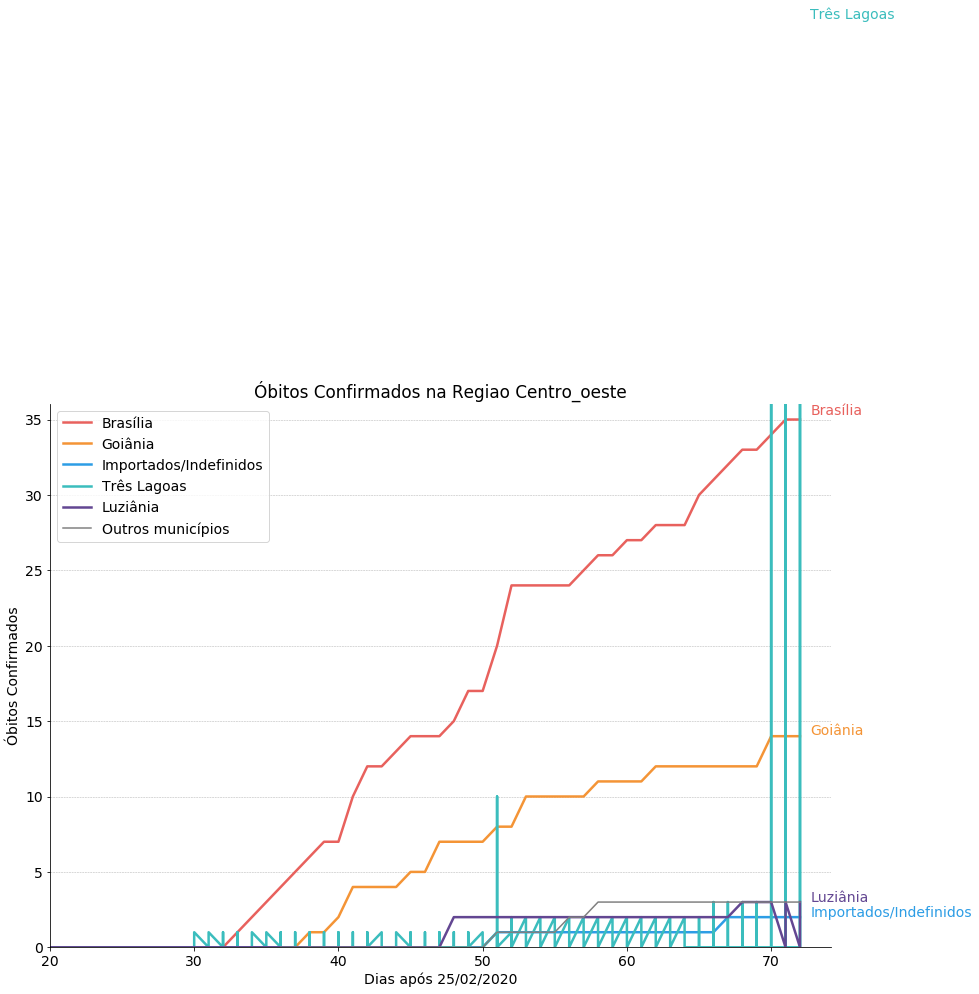

In [47]:
for r in range(len(reg)) :
    for f in [4, 7] :
        
        Regiao_c = list(df_cidades[df_cidades['region'] == reg[r]].sort_values(df_cidades.columns[f + 1], ascending = False)['city'].unique())
        
        plt.rc('font', size = 14)
        plt.rcParams['figure.figsize'] = [14, 10]
        plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                        labelbottom = "on", left = "off", right = "off", labelleft = "on")
        
        plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
        plt.gca().spines["top"].set_visible(False)    
        plt.gca().spines["right"].set_visible(False)
        plt.gca().get_xaxis().tick_bottom()    
        plt.gca().get_yaxis().tick_left()

        x_max = max(df_Regiao[r][0].iloc[:, 2])
        y_max = max(df_Regiao[r][0].iloc[:, f])
        
        #if f == 6 : y_max *= 100     

        for c in range(len(Regiao_c)) :

            # Real data
            x = list(df_Regiao[r][c].iloc[:, 2])
            
            if f == 5 : 
                y = list(df_Regiao[r][c].iloc[:, f] * 100) 
            else :
                y = list(df_Regiao[r][c].iloc[:, f])

            if c < 5 :
                plt.plot(x, y, marker = ' ', label = Regiao_c[c], color = color[c], lw = 2.5)
                plt.text(x_max * 1.01, max(y, default = 0) * 1.01, Regiao_c[c], color = color[c], fontsize = 14)
            elif c == 5 :
                plt.plot(x, y, marker = ' ', label = 'Outros municípios', color = 'gray', lw = 1.5)
            #else :
                #plt.plot(x, y, marker = ' ', color = 'gray', lw = 1.5)

        plt.xlim(20, x_max * 1.03)
        plt.ylim(0, y_max * 1.03)
        plt.title(label[f] + " na Regiao " + reg[r])
        plt.legend(loc = 2)
        #plt.yscale('log')
        plt.xlabel("Dias após 25/02/2020")
        plt.ylabel(label[f])
        plt.savefig(label[f] + " COVID19 - " + reg[r] + ".png")
        plt.show()

In [13]:
df_PB = []

paraiba_c = list(df_paraiba.sort_values("confirmed", ascending = False)['city'].unique())
df_PB = paraiba_c

for c in range(len(paraiba_c)) :
    df_PB[c] = df_paraiba.loc[df_paraiba['city'] == paraiba_c[c], :]#.drop(['is_last'], axis = 1)
    df_PB[c] = df_PB[c].sort_values('date', ascending = True)
    df_PB[c].reset_index(drop = True, inplace = True)
    
paraiba_c = list(df_paraiba.sort_values("confirmed", ascending = False)['city'].unique())

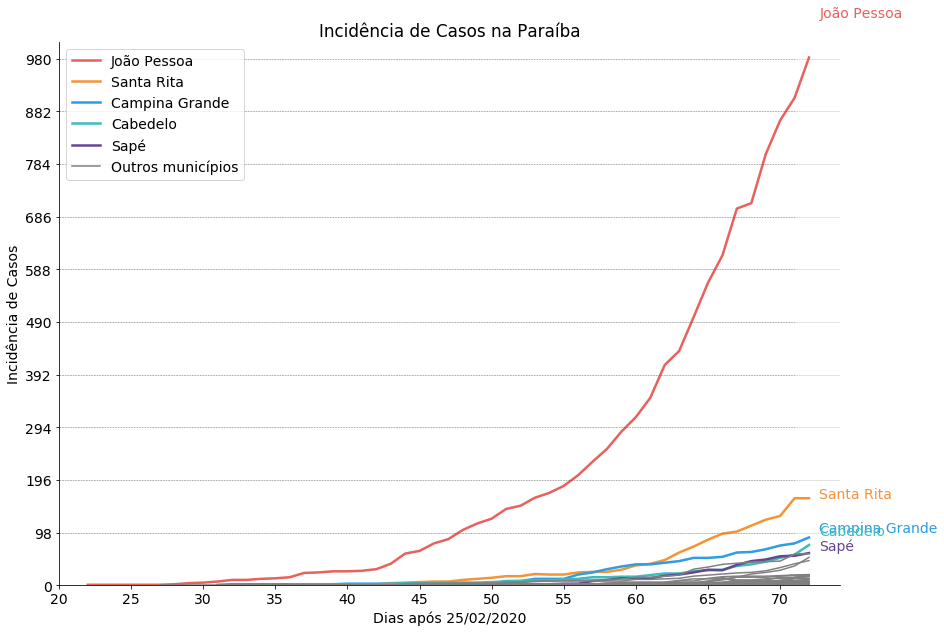

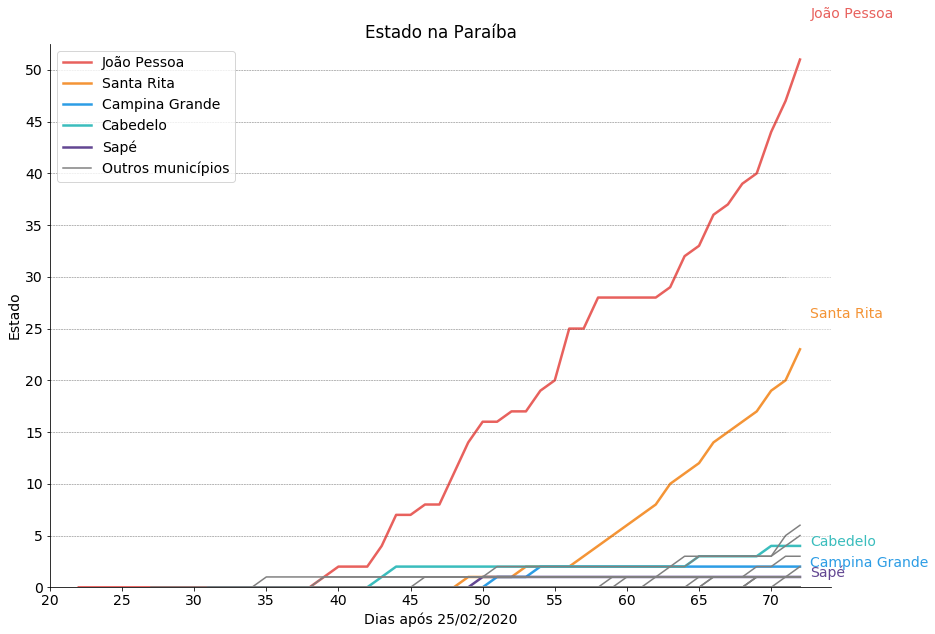

In [42]:
for f in [5, 8] :
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]
    plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                    labelbottom = "on", left = "off", right = "off", labelleft = "on")
    
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    
    x_max = 0
    y_max = 0
    
    for c in range(len(paraiba_c)) :

        # Real data
        x = list(df_PB[c].iloc[:, 2])
        y = list(df_PB[c].iloc[:, f])
        
        if max(x) > x_max :
            x_max = max(x)
        if max(y) > y_max :
            y_max = max(y)
  
        if c < 5 :
            plt.plot(x, y, marker = ' ', label = paraiba_c[c], color = color[c], lw = 2.5)
            plt.text(max(x) * 1.01, (2 * y[-1] - y[-2]), paraiba_c[c], color = color[c], fontsize = 14)
        elif c == 5 :
            plt.plot(x, y, marker = ' ', label = 'Outros municípios', color = 'gray', lw = 1.5)
        else :
            plt.plot(x, y, marker = ' ', color = 'gray', lw = 1.5)
      
        ytick = int(0.10 * y_max)
    
    plt.yticks(range(0, y_max, ytick), fontsize=14)    
    plt.xticks(range(0, x_max, 5), fontsize = 14)
    
    for t in range(0, y_max, ytick) :    
         plt.plot(range(20, x_max), [t] * len(range(20, x_max)), linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)

    plt.xlim(20, x_max * 1.03)
    plt.ylim(0, y_max * 1.03)
    plt.title(label[f] + " na Paraíba")
    plt.legend(loc = 2)
    #plt.yscale('log')
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig(label[f] + " COVID19 Paraiba.png")
    plt.show()

In [23]:
df_hoje = df1.loc[(df["is_last"] == True), :].drop(['date', 'is_last'], axis = 1)
df_hoje = df_hoje.loc[(df_hoje["place_type"] == 'city'), :]
df_hoje = df_hoje.loc[(df_hoje["city"] != 'Importados/Indefinidos'), :]
df_hoje['city_ibge_code'] = df_hoje['city_ibge_code'].astype(int).astype(str)

In [ ]:
mapa_casos = folium.Map(
    width = 800, height = 500,
    location = [-15.77972, -47.92972], #[-7, -36.75], # centro paraiba 
    zoom_start = 4,
    tiles = 'cartodbpositron'
)

mapa_casos.choropleth(
    geo_data = geo,
    name = 'choropleth',
    data = df_hoje,
    columns = ['city_ibge_code', 'confirmed'],
    key_on = 'feature.properties.id',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Casos Confirmados',
    legend_fontsize = '14',
    bins = [0, 10, 100, 1000, 10000, 100000]
)
folium.LayerControl().add_to(mapa_casos)

mapa_casos.save('index.html')
mapa_casos

In [30]:
df_UF = []

estados = list(df_estados.sort_values("confirmed", ascending = False)['state'].unique())
df_UF = estados

for e in range(27) :
    df_UF[e] = df_estados.loc[df_estados['state'] == estados[e], :].drop('is_last', axis = 1)
    df_UF[e] = df_UF[e].sort_values('date', ascending = True)
    df_UF[e].reset_index(drop = True, inplace = True)
    
estados = list(df_estados.sort_values("confirmed", ascending = False)['state'].unique())

In [33]:
df_UF[1].columns

Index(['city', 'city_ibge_code', 'date', 'estimated_population_2019',
       'confirmed', 'confirmed_per_100k_inhabitants', 'death_rate', 'deaths',
       'state', 'new_confirmed', 'new_deaths'],
      dtype='object')

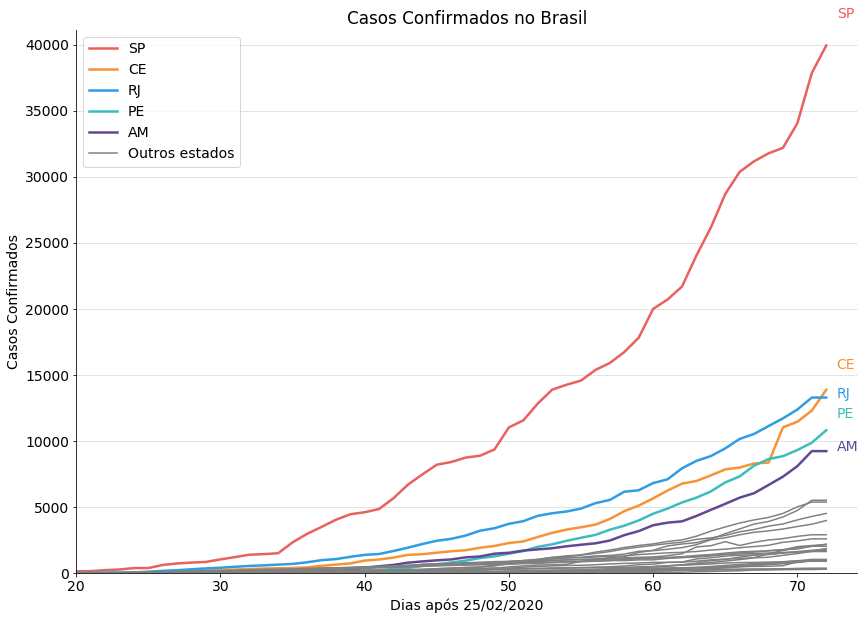

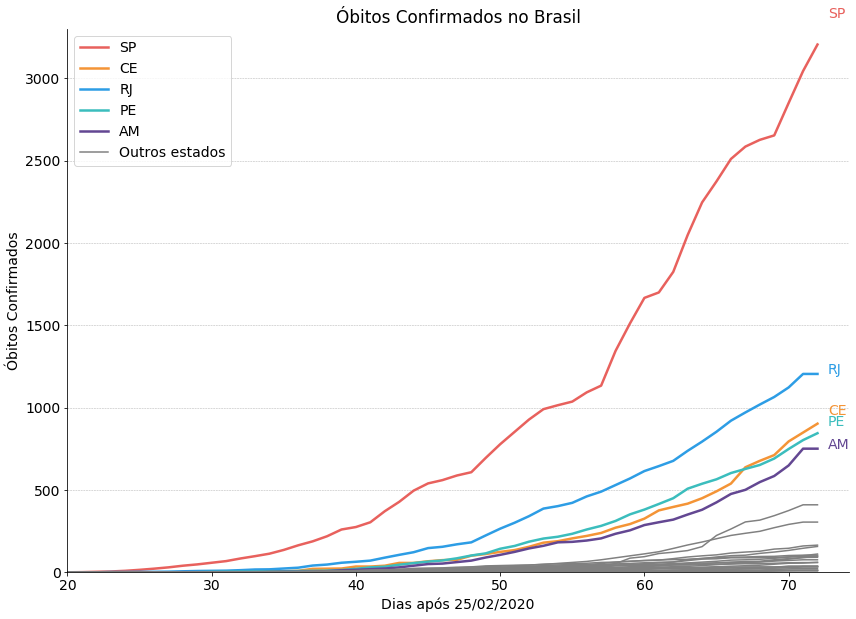

In [37]:
for f in [4, 7] :
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]
    plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                    labelbottom = "on", left = "off", right = "off", labelleft = "on")
    
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    
    # Brasil data
#     x = range(max(df_Brasil.index))
#     y = list(df_Brasil.iloc[x, f - 2])
#     plt.plot(x, y, marker = ' ', color = 'black', label = "Brasil", lw = 2.5) 
#     plt.text(max(x) * 1.01, (2 * y[-1] - y[-2]), "Brasil", color = "black", fontsize = 14)
    
    x_max = max(x)
    y_max = max(y)
    for e in range(27) :

        # Real data
        x = list(df_UF[e].iloc[:, 2])
        y = list(df_UF[e].iloc[:, f])
        
        if max(x) > x_max :
            x_max = max(x)
        if max(y) > y_max :
            y_max = max(y)
  
        if e < 5 :
            plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
            plt.text(max(x) * 1.01, (2 * y[-1] - y[-2]), estados[e], color = color[e], fontsize = 14)
        elif e == 5 :
            plt.plot(x, y, marker = ' ', label = 'Outros estados', color = 'gray', lw = 1.5)
        else :
            plt.plot(x, y, marker = ' ', color = 'gray', lw = 1.5)
            
    plt.xlim(20, x_max * 1.03)
    plt.ylim(0, y_max * 1.03)
    plt.title(label[f] + " no Brasil")
    plt.legend(loc = 2)
    #plt.yscale('log')
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig(label[f] + " COVID19 Brasil.png")
    plt.show()

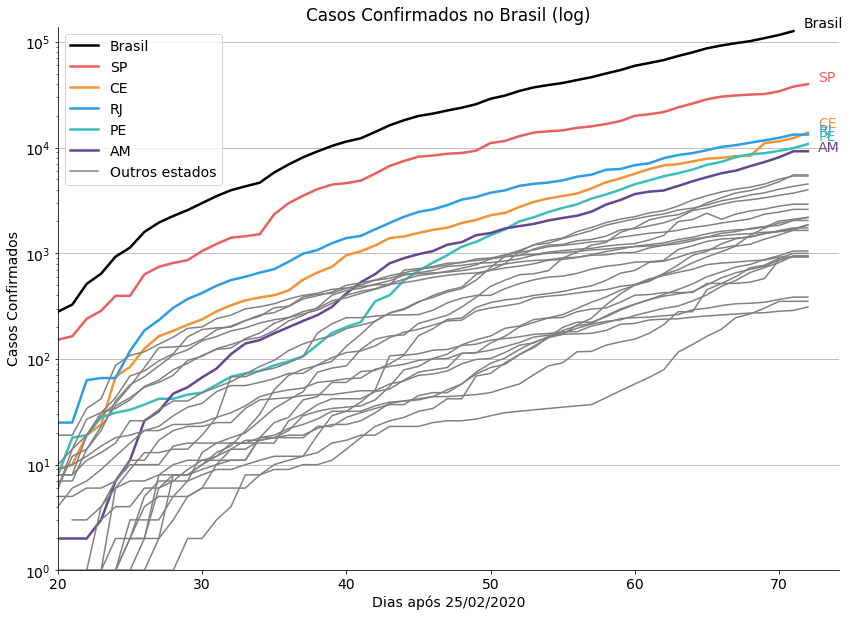

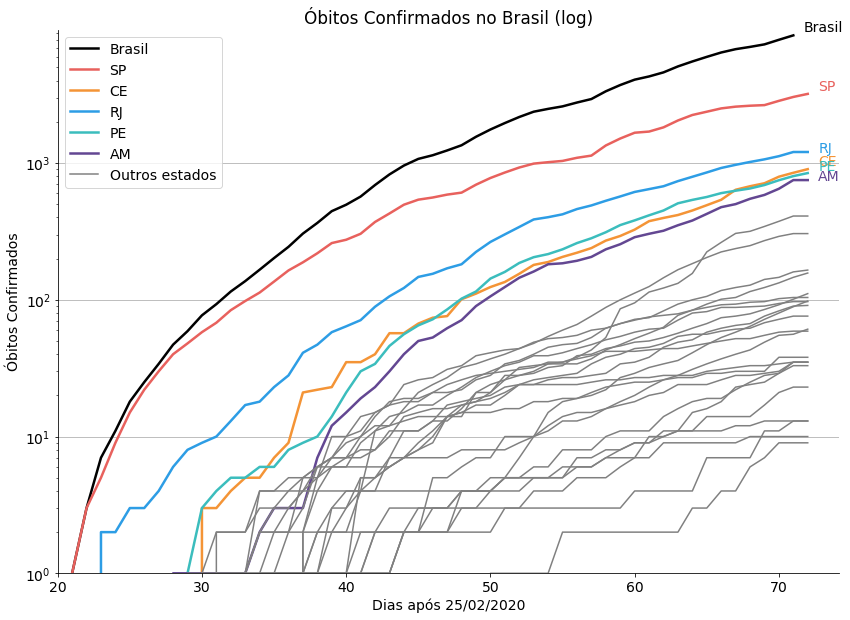

In [36]:
for f in [4, 7] :
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]
    #plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
    #                labelbottom = "on", left = "off", right = "off", labelleft = "on")
    
    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y')
    
    # Brasil data
    x = range(max(df_Brasil.index))
    y = list(df_Brasil.iloc[x, f - 2])
    plt.plot(x, y, marker = ' ', color = 'black', label = "Brasil", lw = 2.5) 
    plt.text(max(x) * 1.01, (2 * y[-1] - y[-2]), "Brasil", color = "black", fontsize = 14)
    
    x_max = max(x)
    y_max = max(y)
    for e in range(27) :

        # Real data
        x = list(df_UF[e].iloc[:, 2])
        y = list(df_UF[e].iloc[:, f])
        
        if max(x) > x_max :
            x_max = max(x)
        if max(y) > y_max :
            y_max = max(y)
  
        if e < 5 :
            plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
            plt.text(max(x) * 1.01, (2 * y[-1] - y[-2]), estados[e], color = color[e], fontsize = 14)
        elif e == 5 :
            plt.plot(x, y, marker = ' ', label = 'Outros estados', color = 'gray', lw = 1.5)
        else :
            plt.plot(x, y, marker = ' ', color = 'gray', lw = 1.5)

    plt.xlim(20, x_max * 1.03)
    plt.ylim(1, y_max * 1.1)
    plt.title(label[f] + " no Brasil (log)")
    plt.legend(loc = 2)
    plt.yscale('log')
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig(label[f] + " COVID19 Brasil log.png")
    plt.show()
